In [1]:
import numpy as np
import pandas as pd
import json
import os
import requests
import urllib.request
import bs4
import re
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
os.chdir('D:/12.COURSERA/01.DATA/ON')

In [3]:
with open('Ward_center_addresses.geojson') as json_data:
    kw_data = json.load(json_data)
data = kw_data['features']
data[0]

{'type': 'Feature',
 'properties': {'OBJECTID': 69572,
  'Municipali': 'Kitchener',
  'Settlement': 'Kitchener'},
 'geometry': {'type': 'Point',
  'coordinates': [-80.42731253061105, 43.441835163545484]}}

In [4]:
XY = ['Municipality','Latitude','Longitude'] 
wards = pd.DataFrame(XY)

#### _Loading JSON file and extracting Ward center coordinates_

In [5]:
for i in data:
    municip = i['properties']['Municipali'] 
    latlon = i['geometry']['coordinates']
    lat = latlon[1]
    lon = latlon[0]
    wards = wards.append({'Municipality': municip,
                          'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)

wards.drop(0, axis=1, inplace=True)
wards.drop([0,1,2], axis=0, inplace=True)
wards.reset_index(drop=True, inplace=True)
wards.to_csv (r'D:\12.COURSERA\01.DATA\ON\Wards_coord_draft.csv', index = False, header=True)

#### _Scrapping Wikipedia to create dataset containing Wards and Communities list for Kitchener_

In [6]:
data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Kitchener_City_Council').read()
data1 = bs4.BeautifulSoup(data, 'lxml')
table = data1.find('table')
table_rows = data1.find_all('tr')

for tr in table_rows:
    td = data1.find_all('td')
    row = [i.text for i in td]
    
df = pd.DataFrame(row)

In [7]:
df_comm = df.drop(df.index[0:59], axis=0)
df_comm.rename(columns={0:'Community'},inplace=True)
df_comm = df_comm.iloc[::3]
df_comm.reset_index(drop=True, inplace=True)
df_comm.drop(df_comm.index[10:22], axis=0, inplace=True)
df_comm['Community'] = df_comm['Community'].map(lambda x: x.rstrip('\n'))

In [8]:
df_ward = df.drop(df.index[0:58], axis=0)
df_ward.rename(columns={0:'Ward'},inplace=True)
df_ward = df_ward.iloc[::3]
df_ward.reset_index(drop=True, inplace=True)
df_ward.drop(df_ward.index[10:22], axis=0, inplace=True)
df_ward['Ward'] = df_ward['Ward'].map(lambda x: x.rstrip('\n'))
df_ward

,Ward
0,Ward 1
1,Ward 2
2,Ward 3
3,Ward 4
4,Ward 5
5,Ward 6
6,Ward 7
7,Ward 8
8,Ward 9
9,Ward 10


#### After verifying that Ward numbers are in ascending order, the table with unique IDs created and replaced values in Ward column 

In [9]:
ward_list = {'Wards':['K01','K02','K03','K04','K05','K06','K07','K08','K09','K10']} 
wwl = pd.DataFrame(ward_list) # Waterloo Ward List
df_ward = df_ward.assign(Ward = wwl.Wards)
df_kit = pd.concat([df_ward, df_comm], axis=1, sort=False) # Replacing Ward column with ward IDs

#Loading manually created CSV file with City of Waterloo communities
df_wl = pd.read_csv('Waterloo_wards.csv')

#Creating dataset with both cities
df_kw = pd.concat([df_kit, df_wl], axis=0, sort=False)
df_kw.reset_index(drop=True, inplace=True)
df_kw

,Ward,Community
0,K01,"Bridgeport, RiverRidge, Rosemount, Heritage Park"
1,K02,"Stanley Park, Centreville"
2,K03,"Parkway, Vanier, Country Hills East, Hidden Va..."
3,K04,"Strasburg, Doon"
4,K05,"Laurentian West, Huron Park, Williamsburg"
5,K06,"Laurentian Hills, Country Hills, Alpine Village"
6,K07,"Forest Heights, Waldau"
7,K08,"Forest Hills, Victoria Hills"
8,K09,"Victoria Park, Southdale, Cherry Hill, Rockway"
9,K10,"Fairfield, Northward, Central Frederick, Audit..."


#### Loading file with Ward center coordinates and manually added unique Ward IDs. This file going to be used to create final Ward dataset containing coordinates, Municipality, Ward IDs and Communities. 

In [16]:
ward = pd.read_csv('Wards_coord.csv')
ward = ward.join(df_kw.set_index('Ward'), on='Ward')
#ward.to_csv (r'D:\12.COURSERA\01.DATA\ON\Wards_comm_list.csv', index = False, header=True)
ward

,Latitude,Longitude,Municipality,Ward,Community
0,43.467507,-80.456767,Kitchener,K01,"Bridgeport, RiverRidge, Rosemount, Heritage Park"
1,43.441835,-80.427313,Kitchener,K02,"Stanley Park, Centreville"
2,43.412796,-80.428959,Kitchener,K03,"Parkway, Vanier, Country Hills East, Hidden Va..."
3,43.382867,-80.431752,Kitchener,K04,"Strasburg, Doon"
4,43.384159,-80.492180,Kitchener,K05,"Laurentian West, Huron Park, Williamsburg"
5,43.415238,-80.487784,Kitchener,K06,"Laurentian Hills, Country Hills, Alpine Village"
6,43.425386,-80.544895,Kitchener,K07,"Forest Heights, Waldau"
7,43.437072,-80.519328,Kitchener,K08,"Forest Hills, Victoria Hills"
8,43.441309,-80.488556,Kitchener,K09,"Victoria Park, Southdale, Cherry Hill, Rockway"
9,43.457672,-80.484576,Kitchener,K10,"Fairfield, Northward, Central Frederick, Audit..."


In [11]:
address = 'Kitchener, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kitchener, ON are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kitchener, ON are 43.453168, -80.494423.


In [12]:
map_kit = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lon, municip, ward in zip(ward['Latitude'], ward['Longitude'], ward['Municipality'], ward['Ward']):
    label = '{}, {}'.format(municip, ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kit)  
    
map_kit

#### _Retrieving venue’s information from FourSquare API_

In [13]:
CLIENT_ID = 'Z4XXP0SAFUZEKMKYVH1U5YNDOYAPNTGHOWSLSHEE4JQEWIGY'
CLIENT_SECRET = 'CRPFN1KI1WWROD2HEREM043LZVWQDV4J2IHLKH2VH42IVRDO'
VERSION = '20200406'
radius = 750
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Z4XXP0SAFUZEKMKYVH1U5YNDOYAPNTGHOWSLSHEE4JQEWIGY
CLIENT_SECRET:CRPFN1KI1WWROD2HEREM043LZVWQDV4J2IHLKH2VH42IVRDO


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [17]:
names = ward['Ward']
latitudes=ward['Latitude']
longitudes=ward['Longitude']

kit_venues = getNearbyVenues(names, latitudes, longitudes)

K01
K02
K03
K04
K05
K06
K07
K08
K09
K10
W01
W02
W03
W04
W05
W06
W07


In [18]:
kit_venues

,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,K01,43.467507,-80.456767,Holy Guacamole,43.466662,-80.457667,Mexican Restaurant
1,K01,43.467507,-80.456767,Kingpin Bowlounge,43.472444,-80.450579,Bowling Alley
2,K01,43.467507,-80.456767,Starbucks,43.465260,-80.459618,Coffee Shop
3,K01,43.467507,-80.456767,A&W,43.464057,-80.463937,Fast Food Restaurant
4,K01,43.467507,-80.456767,Subway,43.466873,-80.458574,Sandwich Place
...,...,...,...,...,...,...,...
239,W07,43.466365,-80.523012,Nougat Bakery,43.463122,-80.523407,Bakery
240,W07,43.466365,-80.523012,Eating Well Organically,43.462859,-80.521701,Grocery Store
241,W07,43.466365,-80.523012,Eyes On King,43.462820,-80.521410,Optical Shop
242,W07,43.466365,-80.523012,Sobeys Bridgeport,43.469879,-80.515248,Grocery Store


In [19]:
kit_venues.groupby('Ward').count()

,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Ward,,,,,,
K01,22,22,22,22,22,22
K02,5,5,5,5,5,5
K04,4,4,4,4,4,4
K05,4,4,4,4,4,4
K06,14,14,14,14,14,14
K07,12,12,12,12,12,12
K08,28,28,28,28,28,28
K09,6,6,6,6,6,6
K10,17,17,17,17,17,17


In [20]:
print('There are {} uniques categories.'.format(len(kit_venues['Venue Category'].unique())))

There are 97 uniques categories.


#### _One Hot Encoding Technique_

In [21]:
kit_onehot = pd.get_dummies(kit_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kit_onehot['Ward'] = kit_venues['Ward'] 

# move neighborhood column to the first column
fixed_columns = [kit_onehot.columns[-1]] + list(kit_onehot.columns[:-1])
kit_onehot = kit_onehot[fixed_columns]

kit_onehot.head()

,Ward,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Tea Room,Thai Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wings Joint,Yoga Studio
0,K01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,K01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,K01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,K01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,K01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
kit_grouped = kit_onehot.groupby('Ward').mean().reset_index()
kit_grouped

,Ward,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,...,Tea Room,Thai Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wings Joint,Yoga Studio
0,K01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000
1,K02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,K04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,K05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,K06,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,K07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,K08,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.035714,0.000000,0.000000,...,0.000000,0.035714,0.035714,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,K09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,K10,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000
9,W01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### _Identifying Top 10 venues_

In [23]:
num_top_venues = 10

for hood in kit_grouped['Ward']:
    print("----"+hood+"----")
    temp = kit_grouped[kit_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----K01----
                   venue  freq
0   Fast Food Restaurant  0.14
1            Coffee Shop  0.09
2             Restaurant  0.09
3  General Entertainment  0.05
4         Clothing Store  0.05
5    Sporting Goods Shop  0.05
6                    Pub  0.05
7                Brewery  0.05
8         Hardware Store  0.05
9          Bowling Alley  0.05


----K02----
               venue  freq
0         Restaurant   0.2
1        Pizza Place   0.2
2               Park   0.2
3              Trail   0.2
4        Bus Station   0.2
5      Movie Theater   0.0
6              Plaza   0.0
7           Pharmacy   0.0
8          Pet Store   0.0
9  Outdoor Sculpture   0.0


----K04----
                 venue  freq
0          Pizza Place  0.25
1             Pharmacy  0.25
2                 Park  0.25
3                  Spa  0.25
4  American Restaurant  0.00
5          Record Shop  0.00
6                Plaza  0.00
7            Pet Store  0.00
8    Outdoor Sculpture  0.00
9         Optical Shop  0.00


-

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ward'] = kit_grouped['Ward']

for ind in np.arange(kit_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kit_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
#neighborhoods_venues_sorted.to_csv (r'D:\12.COURSERA\01.DATA\ON\Community_sorted.csv', index = False, header=True)

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,K01,Fast Food Restaurant,Coffee Shop,Restaurant,Hardware Store,Sporting Goods Shop,Construction & Landscaping,Pizza Place,Mexican Restaurant,Pub,Rental Car Location
1,K02,Park,Restaurant,Trail,Bus Station,Pizza Place,Yoga Studio,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,Department Store
2,K04,Pizza Place,Pharmacy,Park,Spa,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner
3,K05,Furniture / Home Store,Park,Coffee Shop,Bar,Yoga Studio,Department Store,Dim Sum Restaurant,Diner,Discount Store,Fast Food Restaurant
4,K06,Convenience Store,Park,Bus Station,Skating Rink,Fast Food Restaurant,Discount Store,Clothing Store,Shopping Mall,Bank,Grocery Store


#### _k-Mean Clustering_

In [30]:
kclusters = 5

kit_grouped_clustering = kit_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kit_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 3, 1, 1, 1, 4, 1, 1])

In [33]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace = True)
neighborhoods_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,K01,Fast Food Restaurant,Coffee Shop,Restaurant,Hardware Store,Sporting Goods Shop,Construction & Landscaping,Pizza Place,Mexican Restaurant,Pub,Rental Car Location
1,K02,Park,Restaurant,Trail,Bus Station,Pizza Place,Yoga Studio,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,Department Store
2,K04,Pizza Place,Pharmacy,Park,Spa,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner
3,K05,Furniture / Home Store,Park,Coffee Shop,Bar,Yoga Studio,Department Store,Dim Sum Restaurant,Diner,Discount Store,Fast Food Restaurant
4,K06,Convenience Store,Park,Bus Station,Skating Rink,Fast Food Restaurant,Discount Store,Clothing Store,Shopping Mall,Bank,Grocery Store


In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_, allow_duplicates=False)

kit_merged = ward

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kit_merged = kit_merged.join(neighborhoods_venues_sorted.set_index('Ward'), on='Ward')

kit_merged.dropna(axis=0, inplace=True)
#kit_merged['Cluster Labels'] = round(kit_merged['Cluster Labels'],0)
kit_merged['Cluster Labels'] = kit_merged['Cluster Labels'].astype(int)
kit_merged.head()
#kit_merged.to_csv (r'D:\12.COURSERA\01.DATA\ON\Community_clusters.csv', index = False, header=True)

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude],  zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kit_merged['Latitude'], kit_merged['Longitude'], kit_merged['Ward'], kit_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [38]:
kit_merged.loc[kit_merged['Cluster Labels'] == 0, kit_merged.columns[[3,4] + list(range(5, kit_merged.shape[1]))]]

,Ward,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,W04,"Colonial Acres, Rural East Country Squire, Gle...",0,Indian Restaurant,Pizza Place,Martial Arts Dojo,Furniture / Home Store,Health & Beauty Service,Arts & Crafts Store,BBQ Joint,Bakery,Department Store,Dim Sum Restaurant


In [39]:
kit_merged.loc[kit_merged['Cluster Labels'] == 1, kit_merged.columns[[3,4] + list(range(5, kit_merged.shape[1]))]]

,Ward,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,K01,"Bridgeport, RiverRidge, Rosemount, Heritage Park",1,Fast Food Restaurant,Coffee Shop,Restaurant,Hardware Store,Sporting Goods Shop,Construction & Landscaping,Pizza Place,Mexican Restaurant,Pub,Rental Car Location
1,K02,"Stanley Park, Centreville",1,Park,Restaurant,Trail,Bus Station,Pizza Place,Yoga Studio,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,Department Store
3,K04,"Strasburg, Doon",1,Pizza Place,Pharmacy,Park,Spa,Food & Drink Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner
5,K06,"Laurentian Hills, Country Hills, Alpine Village",1,Convenience Store,Park,Bus Station,Skating Rink,Fast Food Restaurant,Discount Store,Clothing Store,Shopping Mall,Bank,Grocery Store
6,K07,"Forest Heights, Waldau",1,Coffee Shop,Breakfast Spot,Supermarket,Pizza Place,Restaurant,Sandwich Place,Pet Store,Liquor Store,Convenience Store,Bank
7,K08,"Forest Hills, Victoria Hills",1,Fast Food Restaurant,Restaurant,Pizza Place,Grocery Store,Food & Drink Shop,Skating Rink,Greek Restaurant,Gas Station,Discount Store,Convenience Store
9,K10,"Fairfield, Northward, Central Frederick, Audit...",1,Train Station,Restaurant,Concert Hall,German Restaurant,Brewery,Chinese Restaurant,Clothing Store,Coffee Shop,Fast Food Restaurant,Greek Restaurant
10,W01,"Beechwood West, Upper Beechwood, Westvale",1,Pizza Place,Deli / Bodega,Pet Store,Park,Grocery Store,Department Store,Bank,French Restaurant,Dim Sum Restaurant,Diner
11,W02,"Clair Creek Meadows, Clair Hills, Erbsville, L...",1,Video Game Store,Asian Restaurant,Park,Pharmacy,Supermarket,Pizza Place,Ice Cream Shop,Wings Joint,Sandwich Place,Chinese Restaurant
14,W05,"Lexington and University Downs, Lincoln Height...",1,Pizza Place,Pharmacy,Pet Store,Grocery Store,Park,Cosmetics Shop,Coffee Shop,Bar,Sandwich Place,Mediterranean Restaurant


In [40]:
kit_merged.loc[kit_merged['Cluster Labels'] == 2, kit_merged.columns[[3,4] + list(range(5, kit_merged.shape[1]))]]

,Ward,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,W03,"Lakeshore, Lakeshore North/Conservation Meadow...",2,Park,College Classroom,Sandwich Place,Yoga Studio,French Restaurant,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store


In [41]:
kit_merged.loc[kit_merged['Cluster Labels'] == 3, kit_merged.columns[[3,4] + list(range(5, kit_merged.shape[1]))]]

,Ward,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,K05,"Laurentian West, Huron Park, Williamsburg",3,Furniture / Home Store,Park,Coffee Shop,Bar,Yoga Studio,Department Store,Dim Sum Restaurant,Diner,Discount Store,Fast Food Restaurant


In [42]:
kit_merged.loc[kit_merged['Cluster Labels'] == 4, kit_merged.columns[[3,4] + list(range(5, kit_merged.shape[1]))]]

,Ward,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,K09,"Victoria Park, Southdale, Cherry Hill, Rockway",4,Brewery,Ice Cream Shop,Grocery Store,Latin American Restaurant,Baseball Field,Yoga Studio,Furniture / Home Store,Department Store,Dim Sum Restaurant,Diner


#### _Importing monthly rental dataset_

In [36]:
rental = pd.read_csv('Rental_prices.csv')
rental.set_index('Municipality')
rental

,Municipality,Bachelor,1 Bedroom,2 Bedroom,3 Bedroom +
0,Kitchener East,752,974,1168,1321
1,Kitchener Central,774,959,1176,1599
2,Kitchener West,797,1044,1264,1336
3,Waterloo,1032,1197,1354,1337


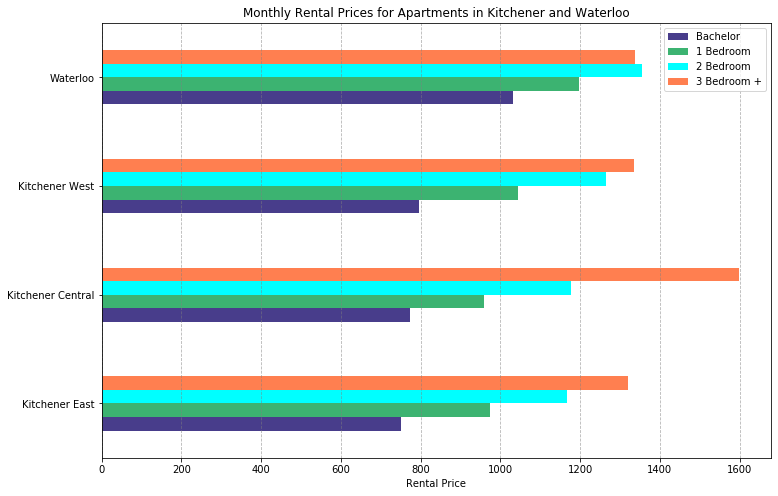

In [37]:
ax = rental.plot(kind='barh', figsize=(12, 8), color=['darkslateblue', 'mediumseagreen', 'cyan', 'coral'])

ax.set_title('Monthly Rental Prices for Apartments in Kitchener and Waterloo')
ax.set_xlabel('Rental Price')
ax.set_yticklabels(rental['Municipality'])
ax.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.6)

plt.show()